In [16]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import explained_variance_score, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional

In [17]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('../../../Data/ETH-USD.csv')
# print(df)
df1=df.reset_index()['Close']


In [18]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [19]:
# 4. Chia train test
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [20]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [21]:


time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [22]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [23]:
# 8. Define LSTM Model

model=Sequential()
model.add(Bidirectional(LSTM(50,return_sequences=True,input_shape=(100,1))))
model.add(Bidirectional(LSTM(50,return_sequences=True)))
model.add(Bidirectional(LSTM(50)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [24]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100


23/23 [==============================] - 16s 172ms/step - loss: 0.0389 - val_loss: 0.1089
Epoch 2/100
23/23 [==============================] - 0s 9ms/step - loss: 0.0171 - val_loss: 0.0099
Epoch 3/100
23/23 [==============================] - 0s 9ms/step - loss: 9.5043e-04 - val_loss: 9.6679e-04
Epoch 4/100
23/23 [==============================] - 0s 9ms/step - loss: 4.0293e-04 - val_loss: 0.0024
Epoch 5/100
23/23 [==============================] - 0s 9ms/step - loss: 3.4393e-04 - val_loss: 8.9135e-04
Epoch 6/100
23/23 [==============================] - 0s 8ms/step - loss: 2.9426e-04 - val_loss: 9.1654e-04
Epoch 7/100
23/23 [==============================] - 0s 8ms/step - loss: 2.9165e-04 - val_loss: 7.6117e-04
Epoch 8/100
23/23 [==============================] - 0s 9ms/step - loss: 2.6145e-04 - val_loss: 8.1599e-04
Epoch 9/100
23/23 [==============================] - 0s 8ms/step - loss: 2.5515e-04 - val_loss: 6.0085e-04
Epoch 10/100
23/23 [==============================] - 0s 9ms/step 

In [25]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

7/7 [==============================] - 0s 3ms/step


In [26]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)
#MAPE
mape = mean_absolute_percentage_error(ytest, y_pred)
print("The mean absolute percentage error (MAPE) on test set: {:.3f}".format(mape))
# EVS
evs = explained_variance_score(ytest, y_pred)
print("The explained variance score (EVS) on test set: {:.3f}".format(evs))


Testing RMSE: 0.3203638528377092
The mean absolute percentage error (MAPE) on test set: 0.036
The explained variance score (EVS) on test set: 0.989


In [27]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)
train_data=scaler.inverse_transform(train_data)
test_data=scaler.inverse_transform(test_data)
val_data=scaler.inverse_transform(val_data)

In [28]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[1:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=x_input.shape[1]
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        # print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, x_input.shape[1], 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, x_input.shape[1],1))
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


In [29]:
df_train = pd.DataFrame(train_data)
df_test = pd.DataFrame(test_data)
df_test.index += df_train.index.stop
df_val = pd.DataFrame(val_data)
df_val.index += df_test.index.stop

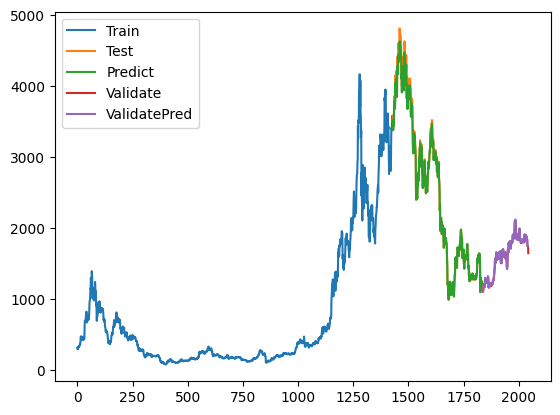

In [30]:
df_train = pd.DataFrame(train_data)
df_test = pd.DataFrame(test_data)
df_test.index += df_train.index.stop
df_val = pd.DataFrame(val_data)
df_val.index += df_test.index.stop
lst_output = scaler.inverse_transform(lst_output)
plt.plot(df_train.index, df_train)
plt.plot(df_test.index, df_test)
plt.plot(pd.RangeIndex(start=df_test.index.start, stop=df_test.index.stop-2), y_pred)
plt.plot(df_val.index, df_val)
plt.plot(pd.RangeIndex(start=df_val.index.start, stop=df_val.index.stop-2), y_pred_val)

plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()